#Pre-Requisites

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pytorch_lightning

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.5 MB/s eta 0:00:00


In [2]:
import os
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import PIL
from tqdm import tqdm
import cv2
import pandas as pd
from sklearn.metrics import classification_report, roc_curve
import torchmetrics

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [4]:
def transform_ml_fn(img):
  img = img.resize((100,100))
  tensor = transforms.ToTensor()(img)
  return tensor

def feature_detector(data, feature_mode='sift', num_features=5):
  data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY).astype('uint8')
  if feature_mode=='sift':
    fd = cv2.xfeatures2d.SIFT_create()
  elif feature_mode=='orb':
    fd = cv2.ORB_create()
  elif feature_mode=='akaze':
    fd = cv2.AKAZE_create()
  else:
    print("Its not available")
    return 0
  des = fd.detectAndCompute(data,None)[1]
  if des is not None and des.shape[0] > num_features:
      des = des[:num_features]
  elif des is None:
    if feature_mode=='sift':
      des = np.zeros((num_features, 128))
    if feature_mode=='orb':
      des = np.zeros((num_features, 32))
    if feature_mode=='akaze':
      des = np.zeros((num_features, 61))
  else:
    if feature_mode=='sift':
      des = np.vstack((des, np.zeros((num_features - des.shape[0], 128))))
    if feature_mode=='orb':
      des = np.vstack((des, np.zeros((num_features - des.shape[0], 32))))
    if feature_mode=='akaze':
      des = np.vstack((des, np.zeros((num_features - des.shape[0], 61))))
  return des.reshape(-1)

def model_return(ckpt_path, model_obj):
  ckpt = torch.load(ckpt_path)
  model_obj.load_state_dict(ckpt['state_dict'])
  return model_obj.eval().cuda()

def accuracy(pred,true):
  class_vector = np.zeros((1,26))
  total_vector = np.zeros((1,26))
  total_correct = 0
  for i in range(len(pred)):
    if pred[i]==true[i]:
      total_correct+=1
      class_vector[0][true[i]]+=1
    total_vector[0][true[i]]+=1
  print("\nOverall Accuracy = ", 100*total_correct/len(pred), "%")
  print("\nClass-Wise Accuracies = ", 100*class_vector/total_vector)
  print(classification_report(pred,true))

def detect(test_loader, model_class):
  pred=[]
  true=[]
  proba=[]
  for i,j in tqdm(test_loader):
    i,j = i.cuda(), j.cuda()
    prob = model_class(i)
    out = prob.max(1, keepdim=True)[1]
    pred.append(out.detach().cpu().item())
    true.append(j.detach().cpu().item())
    proba.append(prob.detach().cpu().numpy())
  print("Confusion Matrix:\n")
  confusion_matrix(pred, true)
  accuracy(pred, true)
  del pred
  MultiClass_ROC(np.array(proba), true)
  del proba, true

def MultiClass_ROC(proba, true):
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = 26
  plt.figure(figsize=(10,10))
  for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(true, [proba[j][0,i] for j in range(proba.shape[0])], pos_label=i)
    plt.plot(fpr[i], tpr[i], label='Class '+str(i)+' vs Rest')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

In [5]:
class Model(pl.LightningModule):

  def __init__(self, model_name, num_classes, loss_mode='normal'):
    super().__init__()
    self.model_name = model_name
    self.num_classes = num_classes
    if self.model_name=='resnet_34':
      self.model = models.resnet34(weights=None)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,self.num_classes)
    if self.model_name=='convnext_tiny':
      self.model = models.convnext_tiny(weights=None)
      self.features = self.model.classifier[-1].in_features 
      self.model.classifier[-1] = nn.Linear(self.features,self.num_classes)
    if self.model_name=='googlenet':
      self.model = models.googlenet(weights=None)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,self.num_classes)
    if self.model_name=='mnasnet0_5':
      self.model = models.mnasnet0_5(weights=None)
      self.features = self.model.classifier[-1].in_features 
      self.model.classifier[-1] = nn.Linear(self.features,self.num_classes)
    if self.model_name=='regnet_y_400mf':
      self.model = models.regnet_y_400mf(weights=None)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,self.num_classes)
    if self.model_name=='resnext50_32x4d':
      self.model = models.resnext50_32x4d(weights=None)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,self.num_classes)
    if self.model_name=='shufflenet_v2_x0_5':
      self.model = models.shufflenet_v2_x0_5(weights=None)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,self.num_classes)
    if self.model_name=='squeezenet1_0':
      self.model = models.squeezenet1_0(weights=None)
      self.features = self.model.classifier[-3].in_channels
      self.model.classifier[-3] = nn.Conv2d(self.features, self.num_classes, kernel_size=(1, 1), stride=(1, 1))
    if self.model_name=='vgg11':
      self.model = models.vgg11(weights=None)
      self.features = self.model.classifier[-1].in_features 
      self.model.classifier[-1] = nn.Linear(self.features,self.num_classes)
    if self.model_name=='wide_resnet50_2':
      self.model = models.wide_resnet50_2(weights=None)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,self.num_classes)
    if self.model_name=='swin_t':
      self.model = models.swin_t(weights=None)
      self.features = self.model.head.in_features
      self.model.head = nn.Linear(self.features,self.num_classes)
    if self.model_name=='densenet_121':
      self.model = models.densenet121(weights=None)
      self.features = self.model.classifier.in_features
      self.model.classifier = nn.Linear(self.features,self.num_classes)
    if self.model_name=='alexnet':
      self.model = models.alexnet(weights=None)
      self.features = self.model.classifier[-1].in_features
      self.model.classifier[-1] = nn.Linear(self.features,self.num_classes)
    if self.model_name=='efficientnet_b0':
      self.model = models.efficientnet.efficientnet_b0(weights=None)
      self.features = self.model.classifier[-1].in_features
      self.model.classifier[-1] = nn.Linear(self.features,self.num_classes)
    if self.model_name=='mobilenet_v3_large':
      self.model = models.mobilenet_v3_large(weights=None)
      self.features = self.model.classifier[-1].in_features
      self.model.classifier[-1] = nn.Linear(self.features,self.num_classes)
    self.loss_mode = loss_mode
    if self.loss_mode=='normal':
      self.loss = nn.CrossEntropyLoss()
    if self.loss_mode=='arcface':
      self.loss = ArcFaceLoss()
    if self.loss_mode=='cosface':
      self.loss = CosFaceLoss(num_classes=self.num_classes, embedding_size=self.features)
    if self.loss_mode=='adaptivefaceloss':
      self.loss = AdaptiveFaceLoss(num_classes=self.num_classes, embedding_size=self.features, scale=30.0)

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_no):
    x, y = batch
    if self.model_name=='googlenet':
      logits = self(x).logits
    else:
      logits = self(x)
    loss = self.loss(logits, y)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(),lr=0.001)

class CosFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, s=30.0, m=0.35):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.s = s
        self.m = m
        self.weights = nn.Parameter(torch.randn(embedding_size, num_classes))

    def forward(self, embeddings, targets):
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weights))
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, targets.view(-1, 1), 1)
        logits = self.s * (cosine - one_hot * self.m)
        return F.cross_entropy(logits, targets)

class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        logits = logits.float()
        cosine = logits / torch.norm(logits, dim=1, keepdim=True)
        theta = torch.acos(cosine)
        one_hot = F.one_hot(labels, num_classes=logits.size(1)).float()
        target_logits = torch.cos(theta + self.m)
        logits = self.s * torch.where(one_hot == 1, target_logits, cosine)
        loss = F.cross_entropy(logits, labels)
        return loss

class AdaptiveFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, scale=30.0):
        super(AdaptiveFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.scale = scale
        self.margin = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.margin)

    def forward(self, logits, targets):
        logits = logits.float()
        targets = targets.long().view(-1, 1).to(logits.device)
        batch_size = logits.size(0)
        mask = targets.expand(batch_size, self.num_classes).eq(torch.arange(self.num_classes).expand(batch_size, -1).to(logits.device))
        cos_theta = logits
        sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
        cos_theta_m = cos_theta * self.margin
        sin_theta_m = torch.sqrt(1.0 - torch.pow(cos_theta_m, 2))
        idx = torch.arange(0, batch_size)
        cos_theta_m[idx, targets] = cos_theta[idx, targets]
        sin_theta_m[idx, targets] = sin_theta[idx, targets]
        cos_theta_m = cos_theta_m * (1 - mask.float()) + cos_theta * mask.float()
        sin_theta_m = sin_theta_m * (1 - mask.float()) + sin_theta * mask.float()
        cos_theta_m = cos_theta_m - self.scale * mask.float()
        loss = F.cross_entropy(torch.cat((cos_theta_m, sin_theta_m), dim=1), targets.view(-1))
        return loss

#Traditional Machine Learning Approach (LFW)

In [ ]:
train_data = datasets.LFWPeople('../data', split='train', download=True, transform=transform_ml_fn)
test_data = datasets.LFWPeople('../data', split='test', download=True, transform=transform_ml_fn)

100%|██████████| 243346528/243346528 [00:07<00:00, 30477903.10it/s]


Extracting ../data/lfw-py/lfw-funneled.tgz to ../data/lfw-py


100%|██████████| 66403/66403 [00:00<00:00, 400187.90it/s]


100%|██████████| 94727/94727 [00:00<00:00, 536575.59it/s]


Using downloaded and verified file: ../data/lfw-py/lfw-funneled.tgz
Extracting ../data/lfw-py/lfw-funneled.tgz to ../data/lfw-py


100%|██████████| 28334/28334 [00:00<00:00, 340744.36it/s]


Using downloaded and verified file: ../data/lfw-py/lfw-names.txt


In [ ]:
train_data_load = torch.utils.data.DataLoader(train_data, batch_size=25,shuffle=True)
test_data_load = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

##Just Flatten

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x_train.append(x)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x_test.append(x0)
  y_test.append(y0)

x_train = torch.stack(x_train).numpy()
y_train = torch.stack(y_train).numpy()
x_test = torch.stack(x_test).numpy()
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:15<00:00, 240.20it/s]


In [ ]:
x_train = x_train.reshape((x_train.shape[0],-1))
y_train = y_train.reshape((y_train.shape[0],-1))
x_test = x_test.reshape((x_test.shape[0],-1))
y_test = y_test.reshape((y_test.shape[0],-1))

In [ ]:
x_train.shape

(9525, 49152)

### For Grayscaled PCA with 0.9 as variance

In [ ]:
PCA_train = PCA(n_components=0.9)
PCA_train.fit(x_train)

PCA(n_components=0.9)

In [ ]:
print(PCA_train.transform(x_train).shape)

(9525, 186)


In [ ]:
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))

<ipython-input-10-c93c7dced17e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_3 = BC()
model_3.fit(x_train,y_train)
print(model_3.score(x_test,y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### For RGB PCA with 186 as n_components

In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)

PCA(n_components=186)

In [ ]:
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)

In [ ]:
x_train.shape

(9525, 186)

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))

<ipython-input-13-c93c7dced17e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_3 = BC()
model_3.fit(x_train,y_train)
print(model_3.score(x_test,y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


##Feature Descriptor (SIFT)

### Num_Features = 1 (128 dimensional each sample)

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'sift',1)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'sift',1)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:57<00:00, 64.48it/s]


In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-8-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, x_test, y_train, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 5

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'sift',5)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'sift',5)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:56<00:00, 65.98it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-14-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 25

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'sift',25)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'sift',25)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:56<00:00, 65.34it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-20-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 100

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'sift',100)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'sift',100)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:57<00:00, 64.05it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-11-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


##Feature Descriptor (ORB)

### Num_Features = 1 (32 dimensional each sample)

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'orb',1)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'orb',1)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:20<00:00, 180.88it/s]


In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-16-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, x_test, y_train, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 5

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'orb',5)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'orb',5)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:20<00:00, 176.98it/s]


In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-21-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 25

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'orb',25)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'orb',25)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:20<00:00, 181.34it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-27-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 100

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'orb',100)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'orb',100)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:20<00:00, 180.39it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-33-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


##Feature Descriptor (AKAZE)

### Num_Features = 1 (61 dimensional each sample)

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'akaze',1)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'akaze',1)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:30<00:00, 122.21it/s]


In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-11-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, x_test, y_train, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 5

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'akaze',5)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'akaze',5)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:29<00:00, 123.98it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-11-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 25

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'akaze',25)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'akaze',25)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:29<00:00, 126.78it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-17-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


### Num_Features = 100

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for x,y in tqdm(train_data_load):
  x = torch.squeeze(x,dim=0)
  x = torch.permute(x,[1,2,0])*255
  des = feature_detector(x.numpy(),'akaze',100)
  x_train.append(des)
  y_train.append(y)

for x0,y0 in tqdm(test_data_load):
  x0 = torch.squeeze(x0,dim=0)
  x0 = torch.permute(x0,[1,2,0])*255
  des = feature_detector(x0.numpy(),'akaze',100)
  x_test.append(des)
  y_test.append(y0)

x_train = np.array(x_train)
y_train = torch.stack(y_train).numpy()
x_test = np.array(x_test)
y_test = torch.stack(y_test).numpy()

100%|██████████| 3708/3708 [00:30<00:00, 120.78it/s]


In [ ]:
PCA_train = PCA(n_components=186)
PCA_train.fit(x_train)
x_train = PCA_train.transform(x_train)
x_test = PCA_train.transform(x_test)
del PCA_train

In [ ]:
model_1 = DTC()
model_1.fit(x_train,y_train)
print(model_1.score(x_test,y_test))
del model_1

0.0


In [ ]:
model_2 = RFC(n_estimators = 18)
model_2.fit(x_train,y_train)
print(model_2.score(x_test,y_test))
del model_2

<ipython-input-9-8bdc39bb62f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_2.fit(x_train,y_train)


0.0


In [ ]:
model_4 = ABC()
model_4.fit(x_train,y_train)
print(model_4.score(x_test,y_test))
del model_4

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


In [ ]:
model_5 = SVC(kernel='rbf')
model_5.fit(x_train,y_train)
print(model_5.score(x_test,y_test))
del model_5, x_train, y_train, x_test, y_test

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0


# Traditional CNNs Approach (LFW)

In [ ]:
alexnet = Model('alexnet',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/alexnet', benchmark=True)
trainer.fit(alexnet, train_data_load)
del trainer, alexnet

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | AlexNet          | 80.6 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
80.6 M    Trainable params
0         Non-trainable params
80.6 M    Total params
322.230   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/alexnet/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('alexnet',5749))
detect(test_data_load, Model_Test)

100%|██████████| 3708/3708 [00:28<00:00, 131.36it/s]

Overall Accuracy = 0.0 %


In [ ]:
vgg11 = Model('vgg11',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/vgg11', benchmark=True)
trainer.fit(vgg11, train_data_load)
del trainer, vgg11

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG              | 152 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
152 M     Trainable params
0         Non-trainable params
152 M     Total params
609.280   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/vgg11/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('vgg11',5749))
detect(test_data_load, Model_Test)

100%|██████████| 3708/3708 [00:32<00:00, 114.58it/s]

Overall Accuracy = 0.0 %


In [ ]:
googlenet = Model('googlenet',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/googlenet', benchmark=True)
trainer.fit(googlenet, train_data_load)
del trainer, googlenet

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | GoogLeNet        | 17.9 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
17.9 M    Trainable params
0         Non-trainable params
17.9 M    Total params
71.490    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/googlenet/lightning_logs/version_5/checkpoints/epoch=19-step=7620.ckpt', Model('googlenet',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:50<00:00, 73.19it/s]

Overall Accuracy = 0.0 %


In [ ]:
resnet_34 = Model('resnet_34',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/resnet_34', benchmark=True)
trainer.fit(resnet_34, train_data_load)
del trainer, resnet_34

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 24.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params
96.936    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/resnet_34/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('resnet_34',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:38<00:00, 96.13it/s] 

Overall Accuracy = 0.0 %


In [ ]:
densenet_121 = Model('densenet_121',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/densenet_121', benchmark=True)
trainer.fit(densenet_121, train_data_load)
del trainer, densenet_121

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | DenseNet         | 12.8 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
12.8 M    Trainable params
0         Non-trainable params
12.8 M    Total params
51.386    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/densenet_121/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('densenet_121',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [01:44<00:00, 35.57it/s]

Overall Accuracy = 0.0 %


In [ ]:
wide_resnet50_2 = Model('wide_resnet50_2',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/wide_resnet50_2', benchmark=True)
trainer.fit(wide_resnet50_2, train_data_load)
del trainer, wide_resnet50_2

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 78.6 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
78.6 M    Trainable params
0         Non-trainable params
78.6 M    Total params
314.456   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/wide_resnet50_2/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('wide_resnet50_2',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [01:02<00:00, 58.96it/s]

Overall Accuracy = 0.0 %


In [ ]:
resnext50_32x4d = Model('resnext50_32x4d',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/resnext50_32x4d', benchmark=True)
trainer.fit(resnext50_32x4d, train_data_load)
del trainer, resnext50_32x4d

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 34.8 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
34.8 M    Trainable params
0         Non-trainable params
34.8 M    Total params
139.038   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/resnext50_32x4d/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('resnext50_32x4d',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:46<00:00, 79.42it/s]

Overall Accuracy = 0.0 %


In [ ]:
squeezenet1_0 = Model('squeezenet1_0',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/squeezenet1_0', benchmark=True)
trainer.fit(squeezenet1_0, train_data_load)
del trainer, squeezenet1_0

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | SqueezeNet       | 3.7 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.739    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/squeezenet1_0/lightning_logs/version_1/checkpoints/epoch=19-step=7620.ckpt', Model('squeezenet1_0',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:32<00:00, 112.51it/s]

Overall Accuracy = 0.0 %


In [ ]:
convnext_tiny = Model('convnext_tiny',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/convnext_tiny', benchmark=True)
trainer.fit(convnext_tiny, train_data_load)
del trainer, convnext_tiny

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ConvNeXt         | 32.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
32.2 M    Trainable params
0         Non-trainable params
32.2 M    Total params
128.964   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/convnext_tiny/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('convnext_tiny',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:44<00:00, 82.65it/s]

Overall Accuracy = 0.0 %


In [ ]:
shufflenet_v2_x0_5 = Model('shufflenet_v2_x0_5',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/shufflenet_v2_x0_5', benchmark=True)
trainer.fit(shufflenet_v2_x0_5, train_data_load)
del trainer, shufflenet_v2_x0_5

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ShuffleNetV2     | 6.2 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.938    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/shufflenet_v2_x0_5/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('shufflenet_v2_x0_5',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:45<00:00, 81.38it/s]

Overall Accuracy = 0.0 %


In [ ]:
mobilenet_v3_large = Model('mobilenet_v3_large',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/mobilenet_v3_large', benchmark=True)
trainer.fit(mobilenet_v3_large, train_data_load)
del trainer, mobilenet_v3_large

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | MobileNetV3      | 11.6 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.266    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/mobilenet_v3_large/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('mobilenet_v3_large',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [00:46<00:00, 79.62it/s]

Overall Accuracy = 0.0 %


In [ ]:
efficientnet_b0 = Model('efficientnet_b0',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/efficientnet_b0', benchmark=True)
trainer.fit(efficientnet_b0, train_data_load)
del trainer, efficientnet_b0

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | EfficientNet     | 11.4 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.488    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/efficientnet_b0/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('efficientnet_b0',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [01:00<00:00, 61.42it/s]

Overall Accuracy = 0.0 %


In [ ]:
swin_t = Model('swin_t',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/swin_t', benchmark=True)
trainer.fit(swin_t, train_data_load)
del trainer, swin_t

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | SwinTransformer  | 31.9 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
31.9 M    Trainable params
0         Non-trainable params
31.9 M    Total params
127.761   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/swin_t/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('swin_t',5749))
detect(test_data_load, Model_Test)


100%|██████████| 3708/3708 [01:24<00:00, 43.64it/s]

Overall Accuracy = 0.0 %


In [ ]:
mnasnet0_5 = Model('mnasnet0_5',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/mnasnet0_5', benchmark=True)
trainer.fit(mnasnet0_5, train_data_load)
del trainer, mnasnet0_5

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | MNASNet          | 8.3 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
33.208    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/mnasnet0_5/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('mnasnet0_5',5749))
detect(test_data_load, Model_Test)

100%|██████████| 3708/3708 [00:37<00:00, 99.66it/s] 

Overall Accuracy = 0.0 %


In [ ]:
regnet_y_400mf = Model('regnet_y_400mf',5749).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Project_2/regnet_y_400mf', benchmark=True)
trainer.fit(regnet_y_400mf, train_data_load)
del trainer, regnet_y_400mf

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | RegNet           | 6.4 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.754    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/regnet_y_400mf/lightning_logs/version_0/checkpoints/epoch=19-step=7620.ckpt', Model('regnet_y_400mf',5749))
detect(test_data_load, Model_Test)

100%|██████████| 3708/3708 [00:57<00:00, 64.43it/s]

Overall Accuracy = 0.0 %


# Traditional CNN Approach (IMFDB)

In [6]:
direct = '/content/drive/MyDrive/CV_Project_2/IMFDB'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [7]:
dataset = datasets.ImageFolder(direct, transform=transform)
print(len(dataset))

9355


In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## Binary Cross Entropy

In [ ]:
mobilenet_v3_large = Model('mobilenet_v3_large',26).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/mobilenet_v3_large', benchmark=True)
trainer.fit(mobilenet_v3_large, train_loader)
del trainer, mobilenet_v3_large

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | MobileNetV3      | 4.2 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.941    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


100%|██████████| 1871/1871 [00:26<00:00, 70.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:


Overall Accuracy =  20.203099946552644 %

Class-Wise Accuracies =  [[12.8440367   8.33333333  0.          0.          1.5625      1.47058824
  30.88235294  3.57142857 46.28099174 25.92592593 23.80952381 13.88888889
  32.65306122  1.1627907  25.64102564  8.16326531  2.66666667  0.
   7.96460177  0.         16.32653061 75.2293578   0.         14.42307692
  48.8372093  56.96202532]]
              precision    recall  f1-score   support

           0       0.13      0.16      0.14        90
           1       0.08      0.16      0.11        49
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.02      1.00      0.03         1
           5       0.01      0.20      0.03         5
           6       0.31      0.48      0.38        44
           7       0.04      0.33      0.06         6
           8       0.46      0.43      0.44       131
           9       0.26      0.12      0.17       170
  

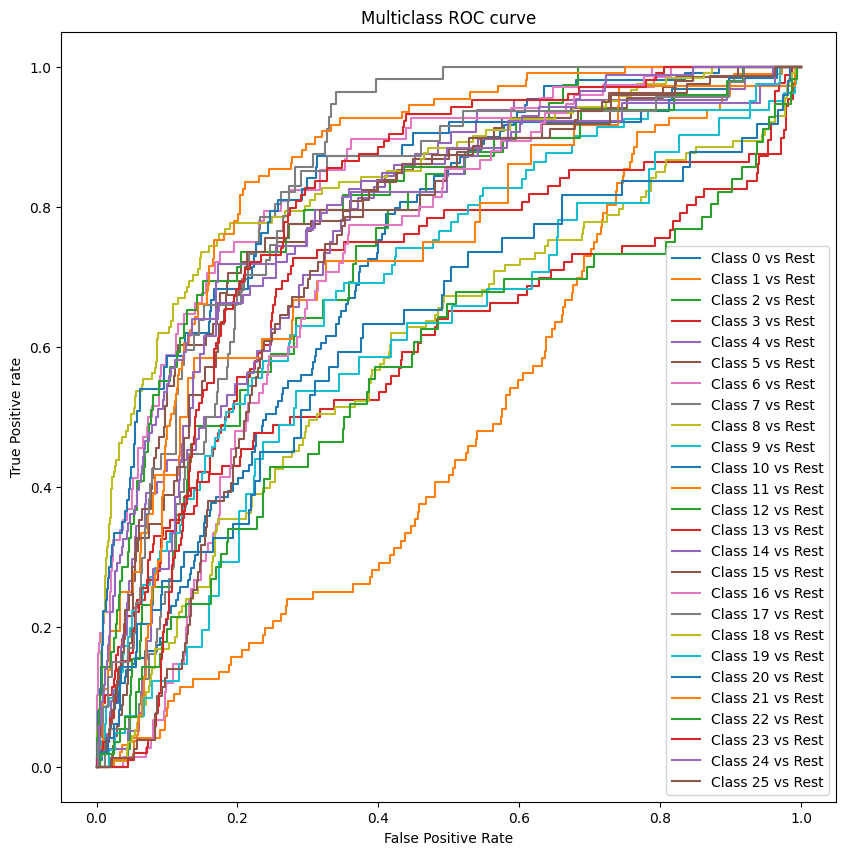

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/mobilenet_v3_large/lightning_logs/version_0/checkpoints/epoch=14-step=28065.ckpt', Model('mobilenet_v3_large',26))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
squeezenet1_0 = Model('squeezenet1_0',26).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/squeezenet1_0', benchmark=True)
trainer.fit(squeezenet1_0, train_loader)
del trainer, squeezenet1_0

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | SqueezeNet       | 748 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
748 K     Trainable params
0         Non-trainable params
748 K     Total params
2.995     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


100%|██████████| 1871/1871 [00:11<00:00, 157.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:


Overall Accuracy =  5.825761624799572 %

Class-Wise Accuracies =  [[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
              precision    recall  f1-score   support

           0       1.00      0.06      0.11      1871
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.

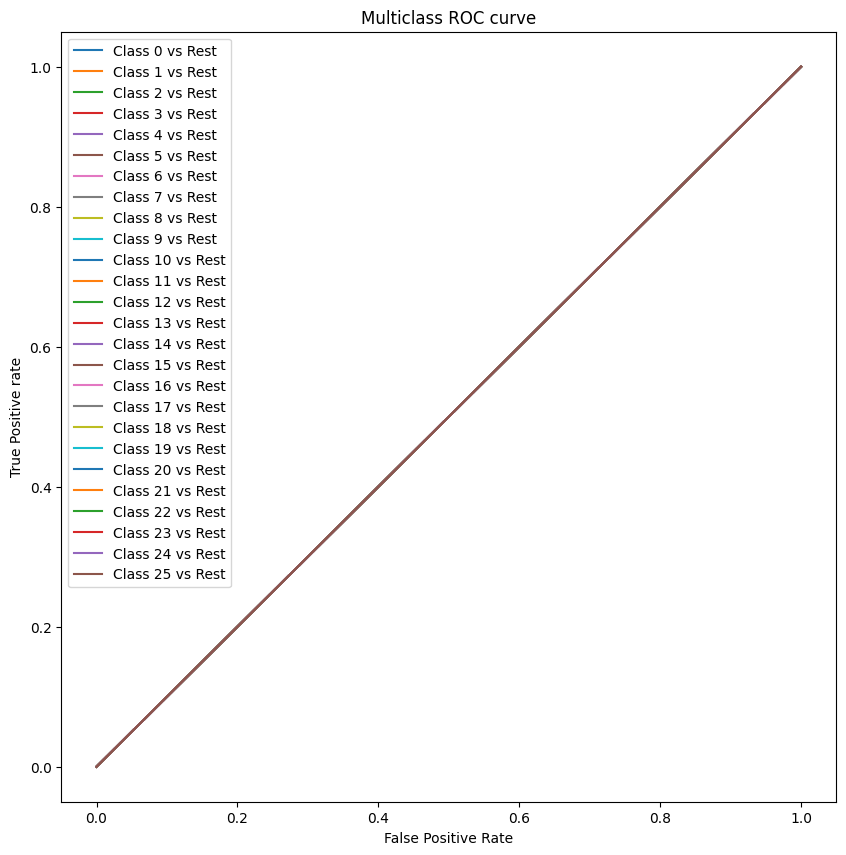

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/squeezenet1_0/lightning_logs/version_0/checkpoints/epoch=14-step=28065.ckpt', Model('squeezenet1_0',26))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
shufflenet_v2_x0_5 = Model('shufflenet_v2_x0_5',26).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/shufflenet_v2_x0_5', benchmark=True)
trainer.fit(shufflenet_v2_x0_5, train_loader)
del trainer, shufflenet_v2_x0_5

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ShuffleNetV2     | 368 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
368 K     Trainable params
0         Non-trainable params
368 K     Total params
1.474     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


100%|██████████| 1871/1871 [00:22<00:00, 82.54it/s]


Confusion Matrix:


Overall Accuracy =  60.342063067878144 %

Class-Wise Accuracies =  [[71.55963303 61.45833333 74.35897436 54.54545455 50.         45.58823529
  67.64705882 41.07142857 66.94214876 64.19753086 46.03174603 52.77777778
  59.18367347 76.74418605 51.28205128 67.34693878 49.33333333 59.57446809
  56.63716814 26.82926829 69.3877551  67.88990826 46.42857143 60.57692308
  65.11627907 77.21518987]]
              precision    recall  f1-score   support

           0       0.72      0.50      0.59       157
           1       0.61      0.64      0.63        92
           2       0.74      0.48      0.59        60
           3       0.55      0.75      0.63        64
           4       0.50      0.58      0.54        55
           5       0.46      0.58      0.51        53
           6       0.68      0.62      0.65        74
           7       0.41      0.62      0.49        37
           8       0.67      0.71      0.69       114
           9       0.64      0.48      0.55     

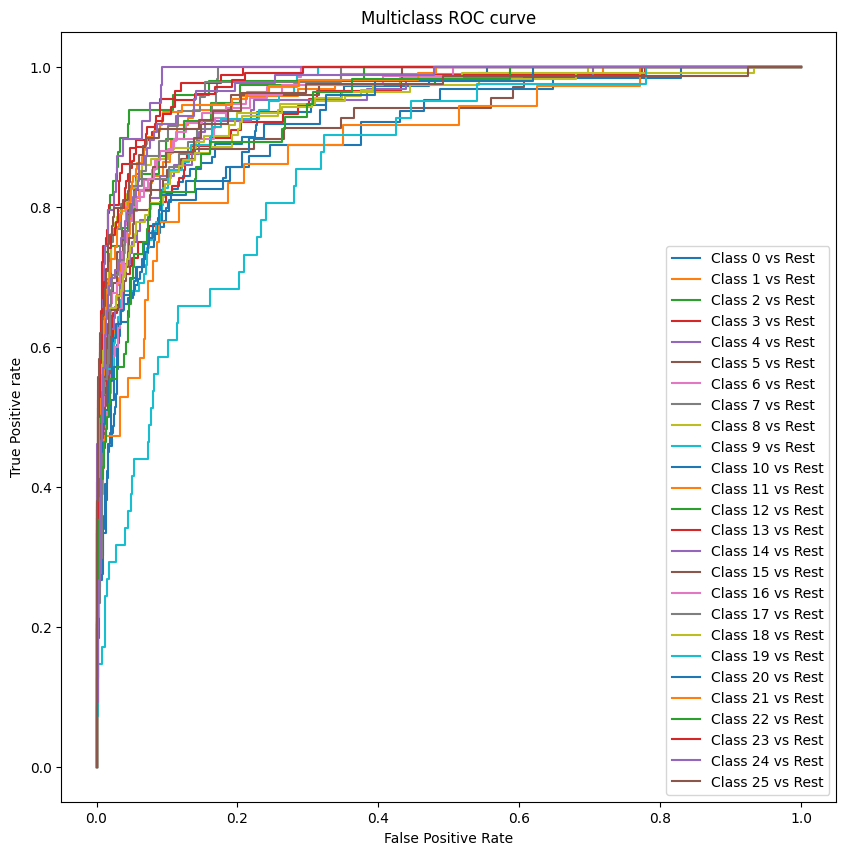

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/shufflenet_v2_x0_5/lightning_logs/version_0/checkpoints/epoch=14-step=28065.ckpt', Model('shufflenet_v2_x0_5',26))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
resnet_34 = Model('resnet_34',26).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/resnet_34', benchmark=True)
trainer.fit(resnet_34, train_loader)
del trainer, resnet_34

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 21.3 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.192    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


100%|██████████| 1871/1871 [00:18<00:00, 103.63it/s]


Confusion Matrix:


Overall Accuracy =  70.97808658471406 %

Class-Wise Accuracies =  [[65.13761468 77.08333333 79.48717949 57.95454545 53.125      79.41176471
  73.52941176 75.         86.7768595  72.83950617 58.73015873 61.11111111
  67.34693878 80.23255814 74.35897436 38.7755102  77.33333333 78.72340426
  69.02654867 39.02439024 69.3877551  79.81651376 75.         69.23076923
  79.06976744 70.88607595]]
              precision    recall  f1-score   support

           0       0.65      0.90      0.76        79
           1       0.77      0.60      0.68       123
           2       0.79      0.63      0.70        49
           3       0.58      0.78      0.67        65
           4       0.53      0.62      0.57        55
           5       0.79      0.64      0.71        84
           6       0.74      0.75      0.74        67
           7       0.75      0.68      0.71        62
           8       0.87      0.63      0.73       166
           9       0.73      0.79      0.76      

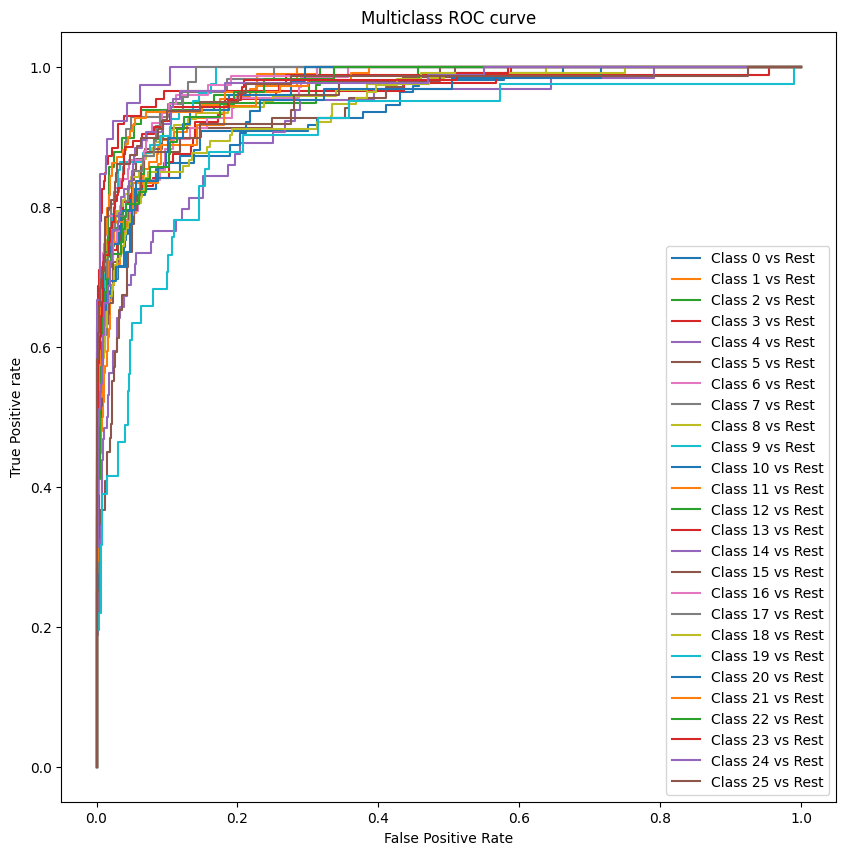

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/resnet_34/lightning_logs/version_0/checkpoints/epoch=14-step=28065.ckpt', Model('resnet_34',26))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
densenet_121 = Model('densenet_121',26).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/densenet_121', benchmark=True)
trainer.fit(densenet_121, train_loader)
del trainer, densenet_121

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | DenseNet         | 7.0 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.922    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


100%|██████████| 1871/1871 [00:46<00:00, 39.93it/s]


Confusion Matrix:


Overall Accuracy =  74.6125066809193 %

Class-Wise Accuracies =  [[80.73394495 82.29166667 66.66666667 76.13636364 62.5        60.29411765
  80.88235294 85.71428571 59.50413223 77.77777778 68.25396825 72.22222222
  85.71428571 87.20930233 84.61538462 67.34693878 77.33333333 82.9787234
  73.45132743 53.65853659 69.3877551  67.88990826 87.5        75.96153846
  80.23255814 73.41772152]]
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       138
           1       0.82      0.88      0.85        90
           2       0.67      0.90      0.76        29
           3       0.76      0.81      0.78        83
           4       0.62      0.65      0.63        62
           5       0.60      0.84      0.70        49
           6       0.81      0.81      0.81        68
           7       0.86      0.65      0.74        74
           8       0.60      0.83      0.69        87
           9       0.78      0.57      0.66       1

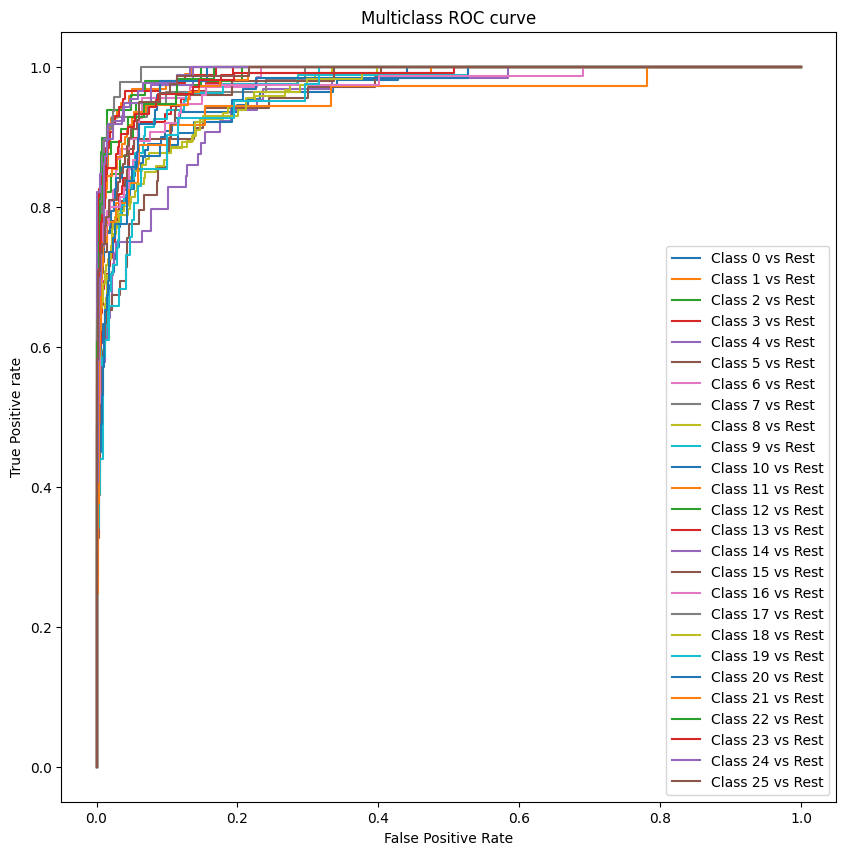

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/densenet_121/lightning_logs/version_0/checkpoints/epoch=14-step=28065.ckpt', Model('densenet_121',26))
detect(test_loader, Model_Test)
del Model_Test

## Other Losses (on Shufflenet_v2_x0_5, ResNet_34 and DenseNet_121)

### ShuffleNet

In [ ]:
shufflenet_v2_x0_5 = Model('shufflenet_v2_x0_5',26,'arcface').train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/shufflenet_v2_x0_5', benchmark=True)
trainer.fit(shufflenet_v2_x0_5, train_loader)
del trainer, shufflenet_v2_x0_5

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | ShuffleNetV2 | 368 K 
1 | loss  | ArcFaceLoss  | 0     
---------------------------------------
368 K     Trainable params
0         Non-trainable params
368 K     Total params
1.474     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



100%|██████████| 1871/1871 [00:24<00:00, 75.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:


Overall Accuracy =  46.231961517904864 %

Class-Wise Accuracies =  [[52.29357798 43.75       10.25641026 21.59090909 28.125      30.88235294
  67.64705882 46.42857143 68.59504132 34.56790123 44.44444444 19.44444444
  73.46938776 73.25581395 56.41025641 40.81632653 40.          6.38297872
  56.63716814  0.         18.36734694 61.46788991  1.78571429 64.42307692
  58.13953488 68.35443038]]
              precision    recall  f1-score   support

           0       0.52      0.33      0.40       174
           1       0.44      0.32      0.37       130
           2       0.10      0.31      0.15        13
           3       0.22      0.45      0.29        42
           4       0.28      0.55      0.37        33
           5       0.31      0.34      0.33        61
           6       0.68      0.45      0.54       102
           7       0.46      0.42      0.44        62
           8       0.69      0.61      0.65       136
           9       0.35      0.29      0.32     

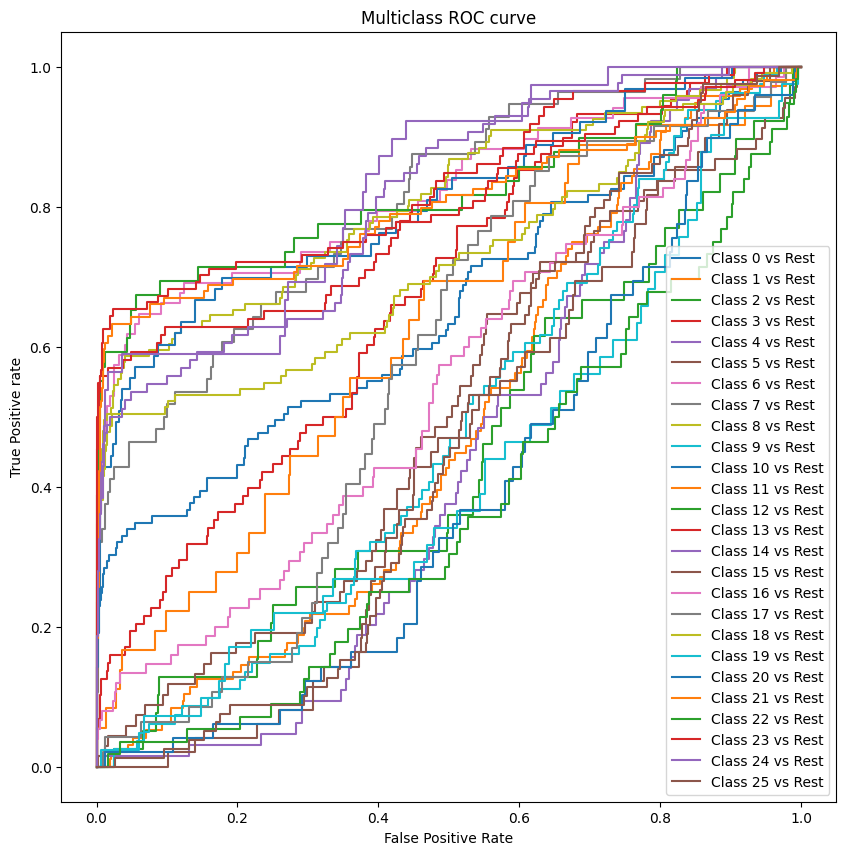

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/shufflenet_v2_x0_5/lightning_logs/version_1/checkpoints/epoch=14-step=28065.ckpt', Model('shufflenet_v2_x0_5',26,'arcface'))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
shufflenet_v2_x0_5 = Model('shufflenet_v2_x0_5',26,'cosface').train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/shufflenet_v2_x0_5', benchmark=True)
trainer.fit(shufflenet_v2_x0_5, train_loader)
del trainer, shufflenet_v2_x0_5

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | ShuffleNetV2 | 368 K 
1 | loss  | CosFaceLoss  | 26.6 K
---------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.580     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



100%|██████████| 1871/1871 [00:39<00:00, 47.26it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:


Overall Accuracy =  4.115446285408872 %

Class-Wise Accuracies =  [[ 0.          0.          0.          0.          0.         13.23529412
   0.          0.         24.79338843  0.          0.          0.
   0.          0.         84.61538462  0.          0.          0.
   0.         12.19512195  0.          0.          0.          0.
   0.          0.        ]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.13      0.12      0.12        77
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.25      0.08      0.12       368
           9       0.00      0.00      0.00        94
          10       

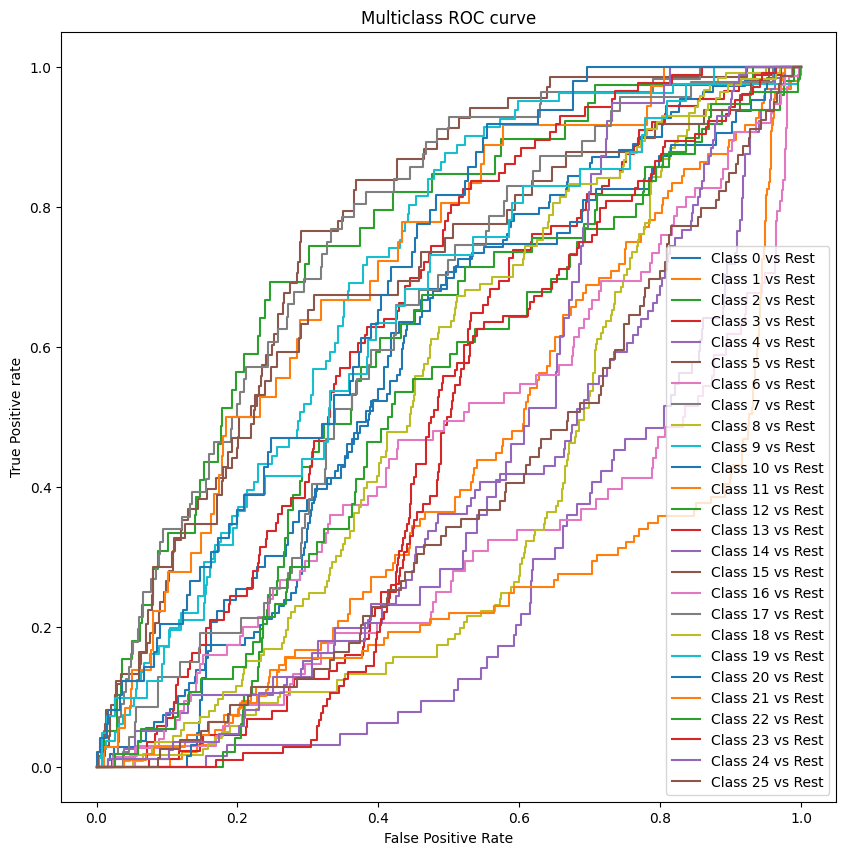

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/shufflenet_v2_x0_5/lightning_logs/version_4/checkpoints/epoch=14-step=28065.ckpt', Model('shufflenet_v2_x0_5',26,'cosface'))
detect(test_loader, Model_Test)
del Model_Test

### ResNet

In [ ]:
resnet_34 = Model('resnet_34',26,'arcface').train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/resnet_34', benchmark=True)
trainer.fit(resnet_34, train_loader)
del trainer, resnet_34

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | ResNet      | 21.3 M
1 | loss  | ArcFaceLoss | 0     
--------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.192    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



100%|██████████| 1871/1871 [00:19<00:00, 94.31it/s] 


Confusion Matrix:


Overall Accuracy =  70.1229289150187 %

Class-Wise Accuracies =  [[73.39449541 75.         66.66666667 72.72727273 57.8125     52.94117647
  76.47058824 80.35714286 71.07438017 82.71604938 52.38095238 58.33333333
  81.63265306 82.55813953 79.48717949 59.18367347 77.33333333 59.57446809
  71.68141593 26.82926829 57.14285714 85.32110092 48.21428571 75.
  67.44186047 75.94936709]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       110
           1       0.75      0.72      0.73       100
           2       0.67      0.65      0.66        40
           3       0.73      0.76      0.74        84
           4       0.58      0.66      0.62        56
           5       0.53      0.82      0.64        44
           6       0.76      0.79      0.78        66
           7       0.80      0.82      0.81        55
           8       0.71      0.76      0.74       113
           9       0.83      0.60      0.69       112
    

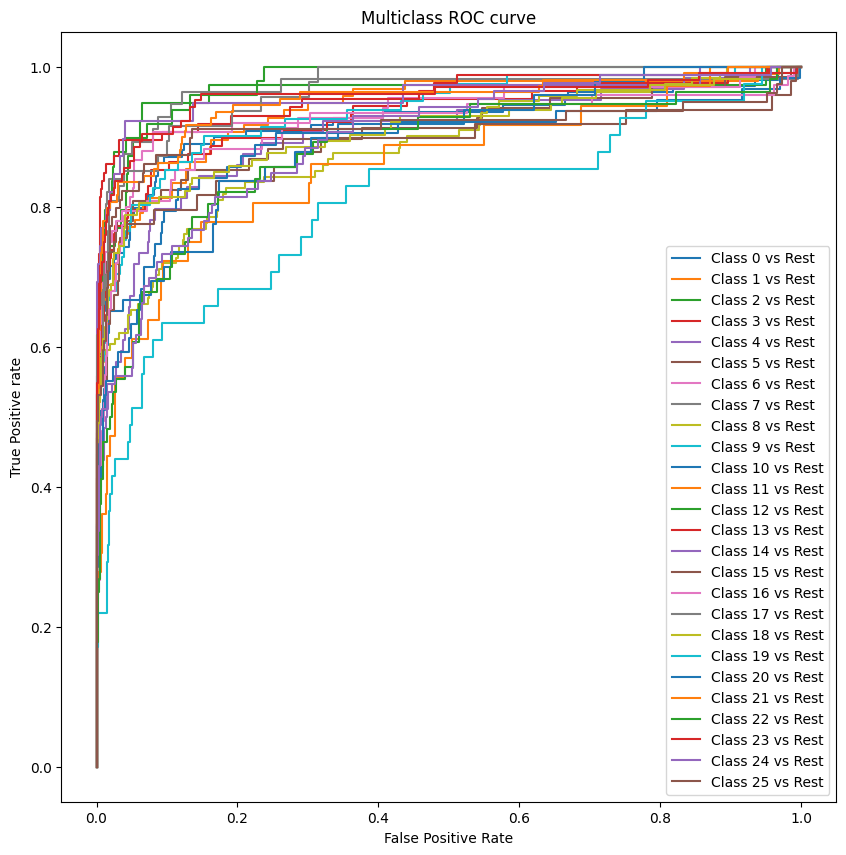

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/resnet_34/lightning_logs/version_1/checkpoints/epoch=14-step=28065.ckpt', Model('resnet_34',26,'arcface'))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
resnet_34 = Model('resnet_34',26,'cosface').train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/resnet_34', benchmark=True)
trainer.fit(resnet_34, train_loader)
del trainer, resnet_34

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | ResNet      | 21.3 M
1 | loss  | CosFaceLoss | 13.3 K
--------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.245    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



100%|██████████| 1871/1871 [00:20<00:00, 92.35it/s]


Confusion Matrix:


Overall Accuracy =  1.282736504543025 %

Class-Wise Accuracies =  [[0.91743119 0.         0.         1.13636364 0.         1.47058824
  0.         7.14285714 0.82644628 1.2345679  0.         0.
  0.         0.         7.69230769 0.         0.         0.
  0.         0.         6.12244898 0.91743119 8.92857143 0.
  1.1627907  2.53164557]]
              precision    recall  f1-score   support

           0       0.01      0.02      0.01        43
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00       106
           3       0.01      0.01      0.01        96
           4       0.00      0.00      0.00        56
           5       0.01      0.01      0.01       100
           6       0.00      0.00      0.00        97
           7       0.07      0.03      0.04       144
           8       0.01      0.03      0.01        35
           9       0.01      0.01      0.01        76
          10       0.00      0.00      0.00  

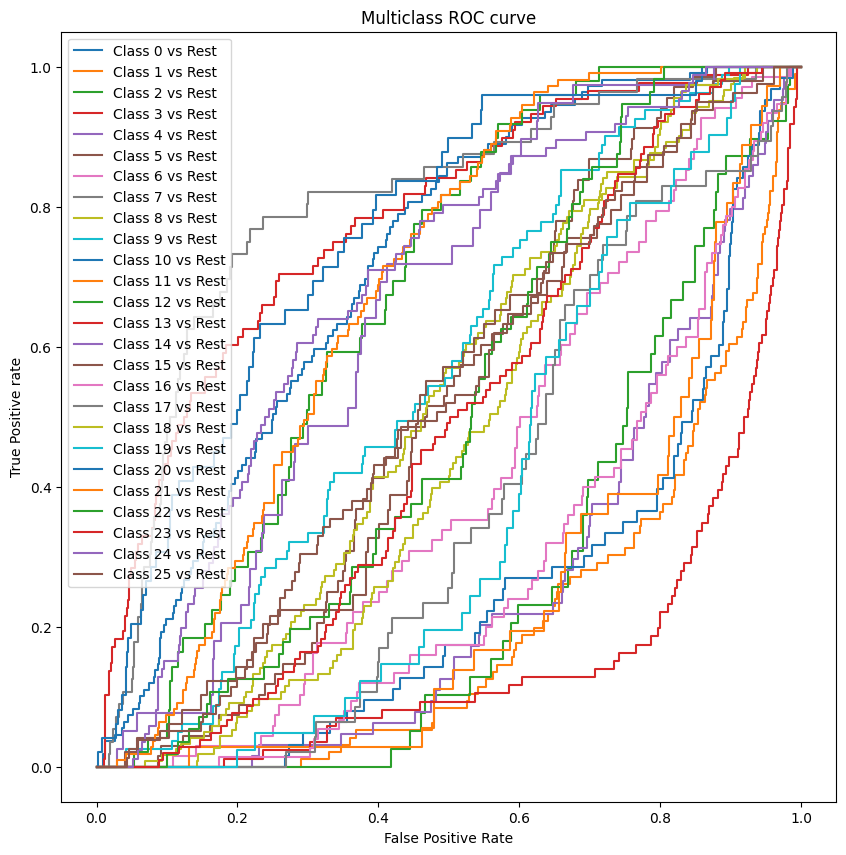

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/resnet_34/lightning_logs/version_2/checkpoints/epoch=14-step=28065.ckpt', Model('resnet_34',26,'cosface'))
detect(test_loader, Model_Test)
del Model_Test

### DenseNet

In [ ]:
densenet_121 = Model('densenet_121',26,'arcface').train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/densenet_121', benchmark=True)
trainer.fit(densenet_121, train_loader)
del trainer, densenet_121

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | DenseNet    | 7.0 M 
1 | loss  | ArcFaceLoss | 0     
--------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.922    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



100%|██████████| 1871/1871 [00:51<00:00, 36.36it/s]


Confusion Matrix:


Overall Accuracy =  78.46071619454837 %

Class-Wise Accuracies =  [[76.14678899 89.58333333 87.17948718 81.81818182 45.3125     60.29411765
  82.35294118 85.71428571 82.6446281  83.95061728 69.84126984 75.
  81.63265306 90.69767442 84.61538462 71.42857143 70.66666667 78.72340426
  62.83185841 46.34146341 75.51020408 89.90825688 85.71428571 85.57692308
  89.53488372 82.27848101]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       105
           1       0.90      0.75      0.82       115
           2       0.87      0.79      0.83        43
           3       0.82      0.74      0.78        97
           4       0.45      0.85      0.59        34
           5       0.60      0.77      0.68        53
           6       0.82      0.82      0.82        68
           7       0.86      0.83      0.84        58
           8       0.83      0.84      0.83       119
           9       0.84      0.65      0.74       104
   

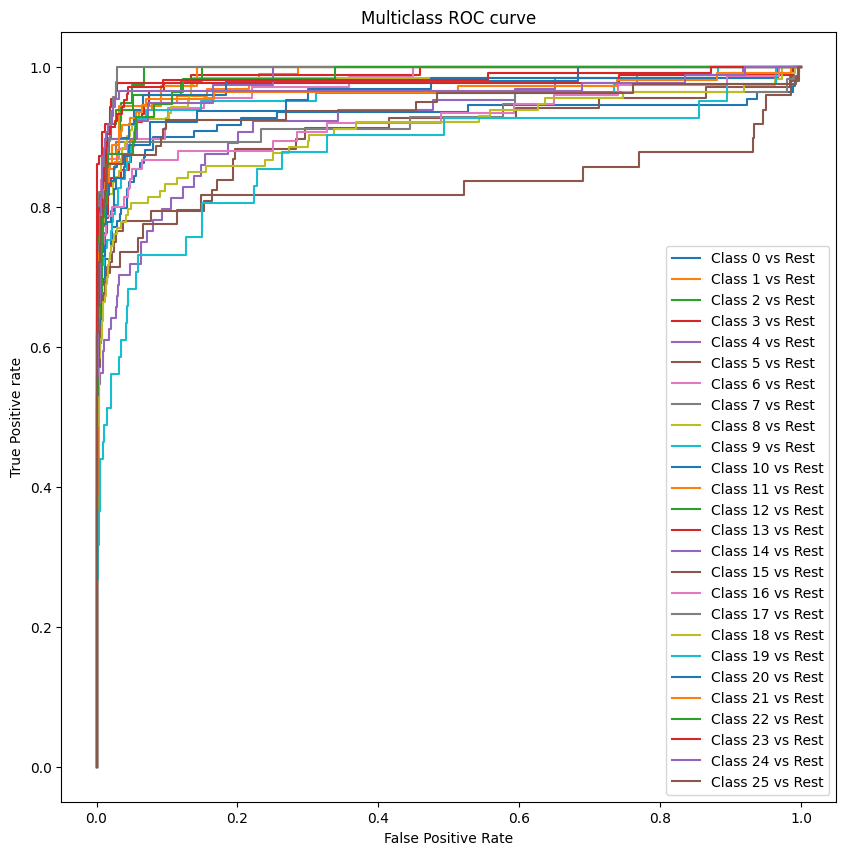

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/densenet_121/lightning_logs/version_1/checkpoints/epoch=14-step=28065.ckpt', Model('densenet_121',26,'arcface'))
detect(test_loader, Model_Test)
del Model_Test

In [ ]:
densenet_121 = Model('densenet_121',26,'cosface').train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=15, default_root_dir='/content/drive/MyDrive/CV_Project_2/Models_IMFDB/densenet_121', benchmark=True)
trainer.fit(densenet_121, train_loader)
del trainer, densenet_121

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | DenseNet    | 7.0 M 
1 | loss  | CosFaceLoss | 26.6 K
--------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
28.029    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

100%|██████████| 1871/1871 [19:55<00:00,  1.57it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:


Overall Accuracy =  1.8706574024585783 %

Class-Wise Accuracies =  [[ 1.26582278  0.          1.78571429  0.          1.53846154  0.
   0.          3.92156863  2.83018868  2.17391304  0.          0.
  23.40425532  0.          0.          0.          6.66666667  4.16666667
   0.         15.90909091  0.          0.          0.          0.
   0.          0.        ]]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01        84
           1       0.00      0.00      0.00        41
           2       0.02      0.01      0.01       129
           3       0.00      0.00      0.00        88
           4       0.02      0.02      0.02        66
           5       0.00      0.00      0.00        90
           6       0.00      0.00      0.00        92
           7       0.04      0.05      0.04        43
           8       0.03      0.09      0.04        34
           9       0.02      0.03      0.03        66
          10      

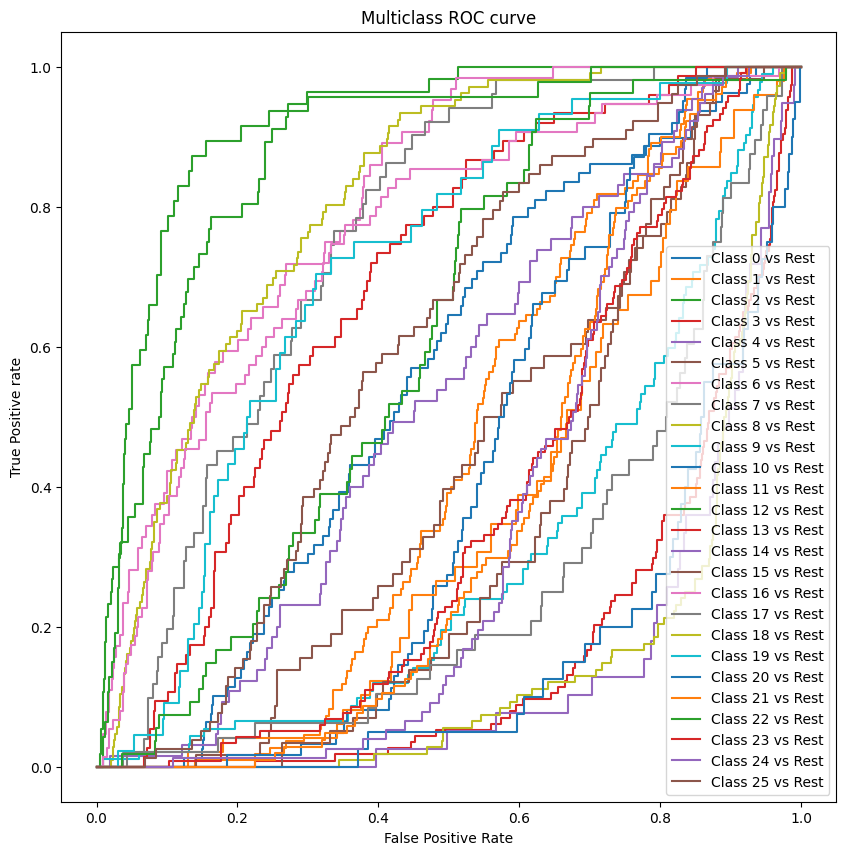

In [9]:
Model_Test = model_return('/content/drive/MyDrive/CV_Project_2/Models_IMFDB/densenet_121/lightning_logs/version_2/checkpoints/epoch=12-step=24323.ckpt', Model('densenet_121',26,'cosface'))
detect(test_loader, Model_Test)
del Model_Test